In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


Notebook Inspired by Jeremy Howard's 'How random forests really work?'

# Introduction
Tabular Data Problem statements observe good results by using ensemble of Decision Trees, Such as Random forests and Gradient Boosting Machines.

In [2]:
# Importing basic set of libraries
from fastai.imports import *
np.set_printoptions(linewidth=130)

## Data Preprocessing

In [3]:
import os
isKaggle= os.environ.get('KAGGLE_KERNEL_RUN_TYPE')

if isKaggle: path = Path('../input/titanic')
else:
    import zipfile, kaggle
    path = Path('titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)
    
df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]

In [4]:
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [5]:
df.index

RangeIndex(start=0, stop=891, step=1)

In Random Forests, we don't generally require to create dummy variables like we did for non-numeric columns(Categorical) in the linear models and neural network.

We can convert those fields to Pandas Categorical variables, which internally in Pandas makes a list of all unique values in the column and replaces each value with a number. The number is just an index for looking up the value in the list of all unique values


In [6]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df.Fare)
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)
    
proc_data(df)
proc_data(test_df)

In [7]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,B96 B98,Q,2.178064
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,B96 B98,S,2.079442
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,B96 B98,Q,2.369075
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,B96 B98,S,2.268252
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,B96 B98,S,2.586824


In [8]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S,2.110213
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,4.280593
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S,2.188856
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.990834
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S,2.202765


We'll make a list of the continous, categorical and dependent variables. 
- we don't consider Pclass a categorical variable. That's because it's ordered(1,2 and 3)
- And decision trees only care about ordered values not the absolute values

In [9]:
cats = ["Sex", "Embarked"]
conts = ["Age", "SibSp", "Parch", "LogFare", "Pclass"]
dep = "Survived"

In [10]:
df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

In [11]:
df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

- "Sex" column is still shown as categorical column in padas.
- However, bts they're now stored as integers, with indices that are looked up in the categories code list shown above(df.Sex.cat.codes)  

# Binary Split/One R
- Fragmented unit of Decision tree later Random Forest or Gradient Boosting Machine

Blueprint
- All rows are split into one of two groups
- based on whether they are above/below some threshold of some column
- Eg: Splitting rows of dataset based on the column 'Sex' by using threshold 0.5

Visualizing using Seaborn library

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


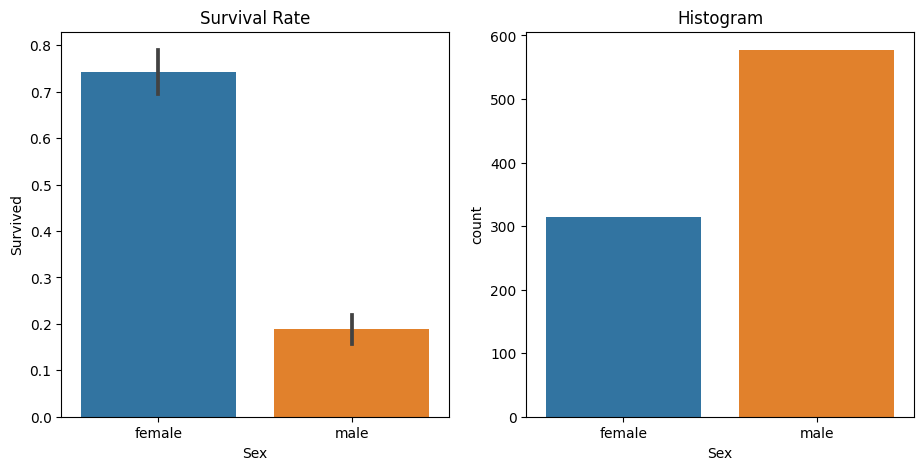

In [12]:
import seaborn as sns

fig, axs = plt.subplots(1,2, figsize=(11, 5))
sns.barplot(data=df, y=dep, x='Sex', ax=axs[0]).set(title="Survival Rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

- Splitting data by Gender is giving quite a good ratios in terms of the survival rate and the number of female/male in the group

- We could create a model which simply says that all female survive and no males do.

In [13]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
# Replacing the categorical values with the codes
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [14]:
trn_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
298,299,1,1,"Saalfeld, Mr. Adolphe",1,24.00,0,0,19988,30.5000,C106,2,3.449988
884,885,0,3,"Sutehall, Mr. Henry Jr",1,25.00,0,0,SOTON/OQ 392076,7.0500,B96 B98,2,2.085672
247,248,1,2,"Hamalainen, Mrs. William (Anna)",0,24.00,0,2,250649,14.5000,B96 B98,2,2.740840
478,479,0,3,"Karlsson, Mr. Nils August",1,22.00,0,0,350060,7.5208,B96 B98,2,2.142510
305,306,1,1,"Allison, Master. Hudson Trevor",1,0.92,1,2,113781,151.5500,C22 C26,2,5.027492


In [15]:
# Creating independent variable 'x' and dependent variable 'y'
def xs_y(df):
    xs = df[cats + conts].copy()
    return xs, df[dep] if dep in df else None

trn_xs, trn_y = xs_y(trn_df)
val_xs, val_y = xs_y(val_df)

### Making prediction

In [16]:
preds = val_xs.Sex == 0

In [17]:
# Measuring Accuracy with mean absolute error
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.21524663677130046

### Alternative (LogFare Based Split)
- We can try splitting continous column like LogFare

In [18]:
df_fare = trn_df[trn_df.LogFare>0]
len(df_fare.index)

655

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='LogFare', ylabel='Density'>

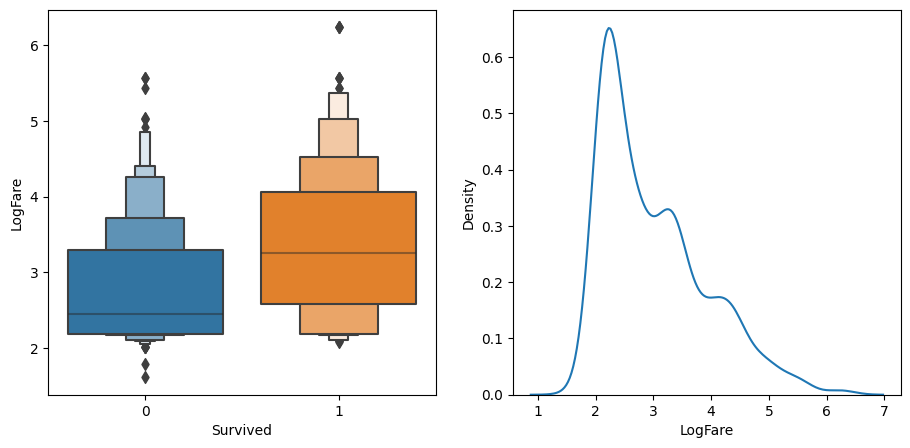

In [19]:
fig, axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y='LogFare', ax=axs[0])
sns.kdeplot(data=df_fare, x='LogFare', ax=axs[1])

The boxenplot above shows quantiles of LogFare for each group of Survived==0 and Survived==1. It shows that the average LogFare for passengers that didn't survive is around 2.5, and for those that did it's around 3.2. So it seems that people that paid more for their tickets were more likely to get put on a lifeboat.

In [20]:
preds= val_xs.LogFare>2.7

In [21]:
mean_absolute_error(val_y, preds)

0.336322869955157

- Less accurate then 'Sex' based split prediction

- We'd like someway to try more columns and breakpoints more easily. 
- We could create a function that returns how good our model is, so we can try more splits.

- `Score` function wouold be used to do this, Instead of MAE we'll calculate measure of Impurity

**Measure of Impurity:** How much the binary split creates two groups where the rows in a group are each similar to each other, or dissimilar.

> We can measure the similarity of rows inside the group by taking the Standard Deviation of the Dependent Variable\
If Higher than rows are diversed and vice versa
We'll then multiply this by the number of rows, since a bigger group as more impact than a smaller group:

In [22]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

Now we can calculate the score for a split by adding up the scores for the LHS and RHS

In [23]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs, y) + _side_score(~lhs,y))/len(y)

In [24]:
# For eg. Score of the impurity
score(trn_xs['Sex'], trn_y, 0.5)

0.40787530982063946

In [25]:
# Impurity score for LogFare split at 2.7
score(trn_xs["LogFare"], trn_y, 2.7)

0.47180873952099694

Trying multiple split with interactive tool

In [26]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

In [27]:
# Doing same for Categorical Columns
interact(nm=cats, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Sex', 'Embarked'), value='Sex'), FloatSlider(value=…

### Finding split with automatization

In [28]:
nm = 'Age'
col = trn_xs['Age']
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  ,
       13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  , 23.  , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  ,
       55.5 , 56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

In [29]:
# Finding the lowest Impurity measure for all the above split
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

6.0

Based on this, it looks like, for instance, that for the Age column, 6 is the optimal cutoff according to our training set.

### Implementing automatic split finder for all columns


In [30]:
def min_col(df, nm):
    col, y = df[nm], df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx], scores[idx]

min_col(trn_df, 'Age')

(6.0, 0.478316717508991)

In [31]:
# Trying for all columns
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (0, 0.40787530982063946),
 'Embarked': (0, 0.47883342573147836),
 'Age': (6.0, 0.478316717508991),
 'SibSp': (4, 0.4783740258817434),
 'Parch': (0, 0.4805296527841601),
 'LogFare': (2.4390808375825834, 0.4620823937736597),
 'Pclass': (2, 0.46048261885806596)}

ccording to this, Sex<=0 is the best split we can use.

We've just re-invented the OneR classifier (or at least, a minor variant of it), which was found to be one of the most effective classifiers in real-world datasets, compared to the algorithms in use in 1993.

- We found earlier that out OneR rule had an error of around 0.215, so we'll keep that in mind as we try out more sophisticated approaches.

# Decision Trees
- We can improve the Impurity measure of the group by spliting the Sex Split further; and find the best split for female and male. 
- To do this we have to repeat previous process twice for female and male group
- We'll remove the 'Sex' from the list of possible split (Since we've already used it, and there's only one possible split for that binary column.

In [32]:
cols.remove("Sex")
ismale = trn_df.Sex==1
males,females = trn_df[ismale],trn_df[~ismale]

In [33]:
# Finding single best split for male
{o:min_col(males, o) for o in cols}

{'Embarked': (0, 0.3875581870410906),
 'Age': (6.0, 0.3739828371010595),
 'SibSp': (4, 0.3875864227586273),
 'Parch': (0, 0.3874704821461959),
 'LogFare': (2.803360380906535, 0.3804856231758151),
 'Pclass': (1, 0.38155442004360934)}

In [34]:
# Finding single best split for females
{o:min_col(females, o) for o in cols}

{'Embarked': (0, 0.4295252982857327),
 'Age': (50.0, 0.4225927658431649),
 'SibSp': (4, 0.42319212059713535),
 'Parch': (3, 0.4193314500446158),
 'LogFare': (4.256321678298823, 0.41350598332911376),
 'Pclass': (2, 0.3335388911567601)}

- We can see that best split for males is Age<=6 and for female is Pclass<=2
- We have created decision tree where our moddel splits the data based on 'Sex' category and depending on result will check either 'Age' or 'Pclass' category.
- We ca now repeat this process for the four new groups that have been formed

- We can use `DecisionTreeClassifier` from sklearn which does exactly the same

In [35]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y)

In [36]:
# Visualizing the tree
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

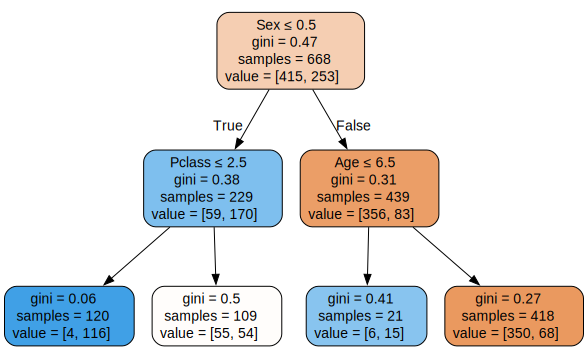

In [37]:
draw_tree(m, trn_xs, size=10)

> It found the exact same split that we found earlier
- Orange Node: Lower survial rate
- Blue Node: Higher survival rate
Node shows how many sample match the condition and shows how many perish or survive.
- Gini: It is another measure of impurity similar to score

In [38]:
def gini(cond):
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2
# What this calculates is the probability that, 
# if you pick two rows from a group, you'll get the same Survived result each time. 
# If the group is all the same, the probability is 1.0, and 0.0 if they're all different:

In [39]:
gini(df.Sex=='female'), gini(df.Sex=='male')

(0.3828350034484158, 0.3064437162277842)

In [40]:
# Let's compare it to OneR version
mean_absolute_error(val_y, m.predict(val_xs))

0.2242152466367713

It's little worse than OneR's Sex based split. It is due to smaller dataset size

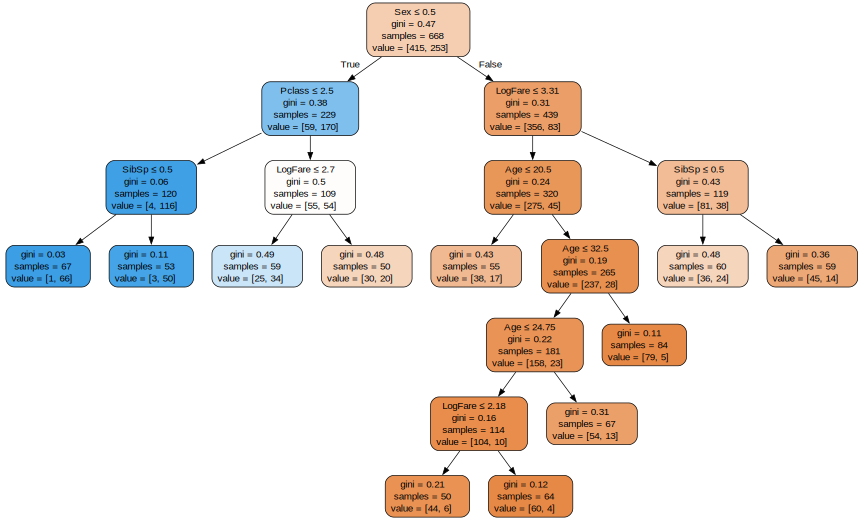

In [41]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=12)

In [42]:
mean_absolute_error(val_y, m.predict(val_xs))

0.18385650224215247

We improved our decision tree based model. Let's try submitting it to Kaggle


In [43]:
test_df[cats] = test_df[cats].apply(lambda x: x.cat.codes)
test_xs,_ = xs_y(test_df)

def subm(preds, suff):
    test_df['Survived'] = preds
    sub_df = test_df[['PassengerId','Survived']]
    sub_df.to_csv(f'sub-{suff}.csv', index=False)

subm(m.predict(test_xs), 'tree')

In [44]:
!head sub-tree.csv

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1


We can see that we didn't create dummy variables but instead just converted the labels into numbers using some (potentially arbitary) ordering of categories

# Random Forest
- We can't make the decision tree much bigger as it would lead to overfitting.

- Alternative: We can create multiple trees then take the average of their prediction. Taking average of their prediction of multiple models is known as *Bagging*
- *The Idea is that we want each model's predictions in the averaged ensemble to be uncorrelated with each other model. That way, if we average the preditions, the average will be equal to the true target value -- That's because the average of lots of uncorrelated random errors is zero.*
- One way we can create a bunch of uncorrelated models is to train each of them on different random subset of the data. That's how we create random forest.

In [45]:
def get_tree(prop=0.75):
    n=len(trn_y)
    idxs= random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])


In [46]:
trees = [get_tree() for t in range(100)]

In [47]:
# Predicting with all trees for validation set
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.2272645739910314

This is similar to `sklearn`'s `RandomForestClassifier` does.
- The main piece in `real` random forest is that as well as choosing random sample of the data for each tree, it also picks a random subset of the column for each split


In [48]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y)
mean_absolute_error(val_y, rf.predict(val_xs))

0.18834080717488788

In [49]:
# Submitting to kaggle
subm(rf.predict(test_xs), 'randomforest')

### Feature Importance
Nice feature of random forests is they can tell us which independent variables were the most important in the model, using feature_importances_

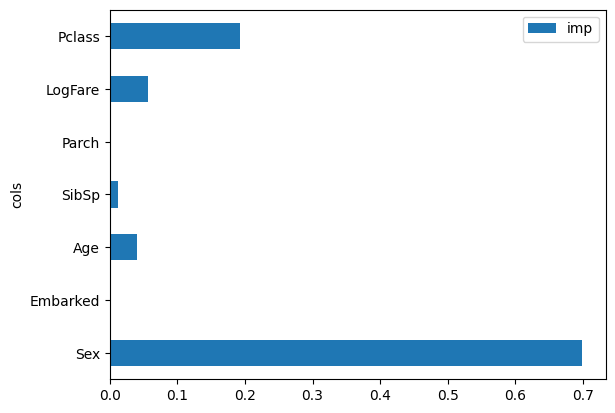

In [50]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

It shows us the order in which the columns are effecting the prediction calculation. It can help you to understand the importance of feature and can also help you to remove unwanted negligible effective columns.

# Conclusion
Takeaways
- More complex models does not always perform better. `OneR` model consisting single binary split performed as nearly good as more complex model. 
- Consider using simple models. Random forest in our case wasn't an improvement to single decision tree,

- Always be careful to benchmark the simple model; they might be good for our problem statement
- Random forest aren't complicated. We understood feature importance. It is insensitive to normalization , interaction or non linear transformation (no preprocessing required). So easy to work with.